In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from vqf.preprocessing import create_clauses
from IPython.display import display
import sys

import warnings

warnings.filterwarnings("ignore")

sys.path.append(f"./../")
from src import SpaceEfficientVQF, Clause

## The Original Clauses from Michal Code

In [3]:
# p = 5
# q = 3

# p = 31
# q = 23

p = 11
q = 7

# p = 241
# q = 233

# p = 13
# q = 11

# p = 557
# q = 523

# p, q = 1481, 997

m = p * q
vqf = SpaceEfficientVQF(m)

## The Limited Clauses 

In [4]:
for c in vqf.selected_clauses:
    print(c.clause)
    print(f"The number of pq variables: {len(c.pq_part.free_symbols)}")

p_2 + 2*q_1 + q_2 - 2*z_2_3 - 1
The number of pq variables: 3
p_2*q_1 + p_3 + q_1*q_2 + q_3 + z_2_3 - 2*z_3_4 - 4*z_3_5 - 1
The number of pq variables: 5
p_2*q_2 + p_3*q_1 + p_4 + q_1*q_3 + z_3_4 - 2*z_4_5 - 4*z_4_6
The number of pq variables: 6
p_2*q_3 + p_3*q_2 + p_4*q_1 + p_5 + z_3_5 + z_4_5 - 2*z_5_6
The number of pq variables: 7
p_3*q_3 + p_4*q_2 + p_5*q_1 + p_6 + z_4_6 + z_5_6 - 1
The number of pq variables: 7
p_4*q_3 + p_5*q_2 + p_6*q_1
The number of pq variables: 6
p_5*q_3 + p_6*q_2
The number of pq variables: 4
p_6*q_3
The number of pq variables: 2


## The Generated superposition Tables

In [5]:
superposition_tables = vqf.superposition_tables
for table in superposition_tables:
    display(table.table)

,q_1,q_2,p_2
0,0,0,1
1,0,1,0
2,1,0,1
3,1,1,0


,p_6,q_3
0,0,0
1,0,1
2,1,0


In [6]:
best_table = vqf.best_superposition_table
best_table.table

,q_1,q_2,q_3,p_6,p_5,p_4
0,0,0,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,1,0
3,0,0,0,0,1,1
4,0,0,0,1,0,0
5,0,0,0,1,0,1
6,0,0,0,1,1,0
7,0,0,0,1,1,1
8,0,0,1,0,0,0
9,0,0,1,0,1,0


In [7]:
table = superposition_tables[0]
display(table.table)

,q_1,q_2,p_2
0,0,0,1
1,0,1,0
2,1,0,1
3,1,1,0


In [8]:
from qiskit.visualization import array_to_latex

desired_state = table.get_init_state()
array_to_latex(desired_state)

<IPython.core.display.Latex object>

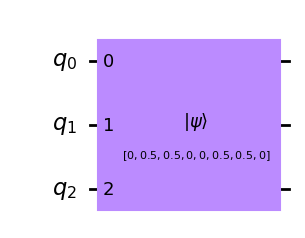

In [10]:

from qiskit import QuantumCircuit
from numpy import log2
n_qubits = int(log2(len(desired_state)))
qc = QuantumCircuit(n_qubits)
qc.initialize(desired_state, range(n_qubits))
qc.draw(output='mpl')

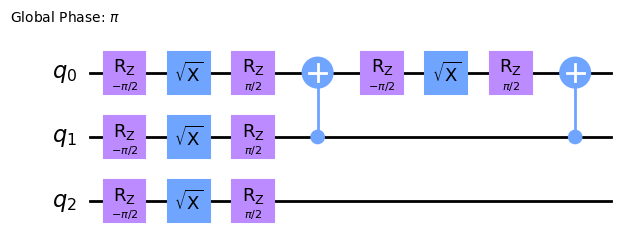

In [11]:
from qiskit import transpile
import pyzx as zx

#basis = ['u3', 'cx']
basis = ['cx', 'h', 'x', 'rz', 'sx']
transpiled_qc = transpile(qc, basis_gates=basis, optimization_level=3)
# Draw the transpiled circuit
transpiled_qc.draw(output='mpl', interactive=True)

In [12]:
from src.circuit_tools import statevector
output_state = statevector(qc)
array_to_latex(output_state)

<IPython.core.display.Latex object>

In [15]:
from qiskit.quantum_info import state_fidelity

fid = state_fidelity(desired_state, output_state)
print(f"Fidelity: {fid}")

Fidelity: 1.0
